In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import numpy as np
import pandas as pd
import re

In [2]:
m5_data = pd.read_pickle('data/KAS_USDT_5m_300_days_data.pkl')
m15_data = pd.read_pickle('data/KAS_USDT_15m_350_days_data.pkl')

In [3]:
float_columns = ['open', 'close', 'high', 'low', 'volume']
m5_data[float_columns] = m5_data[float_columns].apply(pd.to_numeric, downcast='float')
m15_data[float_columns] = m15_data[float_columns].apply(pd.to_numeric, downcast='float')

In [4]:
def apply_label(df):
    df = df.copy()
    df['next_open'] = df['open'].shift(-1)
    df['next_close'] = df['close'].shift(-1)
    
    df['target'] = (df['next_close'] > df['next_open']).astype(int)
    
    df = df[:-1]
    
    df.drop(['next_open', 'next_close'], axis=1, inplace=True)
    
    return df

m5_data = apply_label(m5_data)
m15_data = apply_label(m15_data)

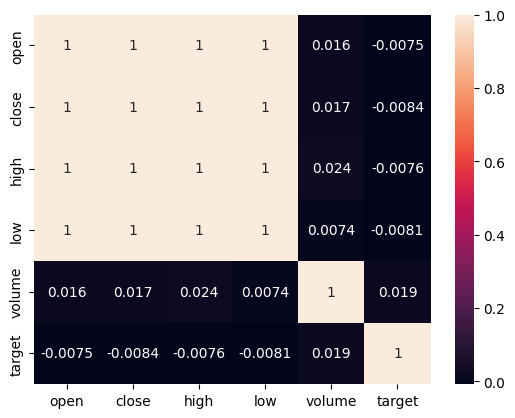

In [5]:
sns.heatmap(m15_data.corr(), annot=True)
plt.show()

In [6]:
def create_features(df):
    df['price_change'] = df['close'] - df['open']
    df['pct_return'] = (df['price_change'] / df['open']) * 100
    df['price_range'] = df['high'] - df['low']

    df['sma_3'] = df['close'].rolling(window=3).mean()
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['ema_3'] = df['close'].ewm(span=3, adjust=False).mean()
    df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()

    df['prev_open'] = df['open'].shift(1)
    df['prev_close'] = df['close'].shift(1)
    df['prev_high'] = df['high'].shift(1)
    df['prev_low'] = df['low'].shift(1)
    df['prev_volume'] = df['volume'].shift(1)

    df.fillna(method='bfill', inplace=True) 

    return df


C:\Users\NVME_1TB\AppData\Local\Temp\ipykernel_18200\2577362301.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


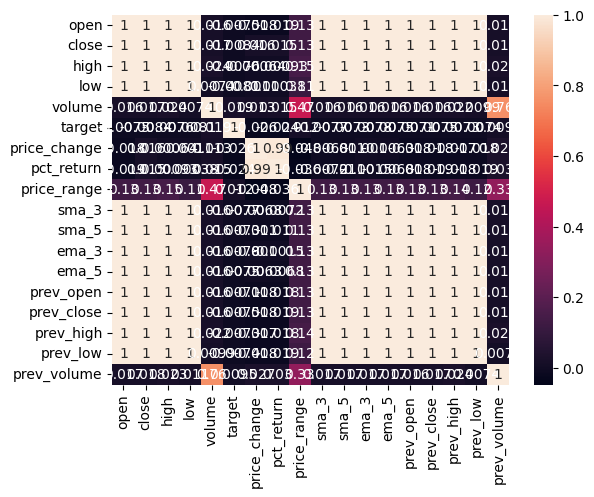

In [7]:
df = create_features(m15_data)

sns.heatmap(df.corr(), annot=True)
plt.show()

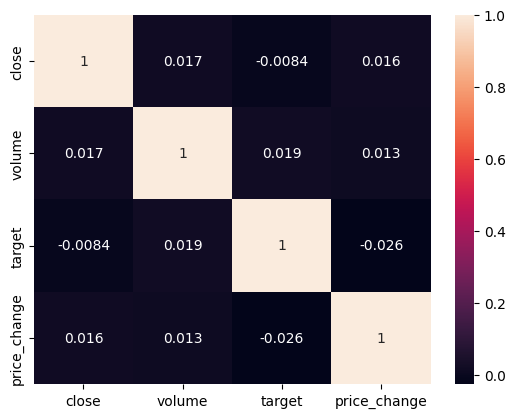

In [8]:
cols_to_drop = ['open', 'high', 'low', 'sma_3', 'ema_3', 'prev_close','prev_open','prev_high',
                 'prev_low','sma_5', 'ema_5', 'pct_return', 'prev_volume', 'price_range']
for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
    else:
        pass

sns.heatmap(df.corr(), annot=True)
plt.show()

In [9]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [10]:
y = df['target']

final_features = [
    'price_change', 'close', 'volume'
]

X = df[final_features]

n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"Number of splits: {tscv.get_n_splits()}")

Number of splits: 5


In [11]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

rf_clf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

svc_clf = SVC(random_state=42, probability=True)

svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

lgbm_clf = LGBMClassifier(random_state=42)

lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'subsample': [0.6, 0.8, 1.0]
}

In [12]:
from sklearn.pipeline import Pipeline

def train_and_evaluate_model(model, param_grid, X, y, tscv, scaler=False):
    steps = []
    if scaler:
        steps.append(('scaler', StandardScaler()))
    steps.append(('classifier', model))
    pipeline = Pipeline(steps)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={'classifier__' + key: val for key, val in param_grid.items()},
        cv=tscv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_score_, grid_search.cv_results_

In [13]:
print("Training Logistic Regression...")
best_log_reg, best_log_reg_score, log_reg_cv_results = train_and_evaluate_model(
    model=LogisticRegression(random_state=42, max_iter=100),
    param_grid=log_reg_param_grid,
    X=X,
    y=y,
    tscv=tscv,
    scaler=True
)
print("\nTraining Random Forest Classifier...")
best_rf, best_rf_score, rf_cv_results = train_and_evaluate_model(
    model=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    X=X,
    y=y,
    tscv=tscv,
    scaler=False
)
print("\nTraining XGBoost Classifier...")
best_xgb, best_xgb_score, xgb_cv_results = train_and_evaluate_model(
    model=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    X=X,
    y=y,
    tscv=tscv,
    scaler=False
)
print("\nTraining Support Vector Machine...")
best_svc, best_svc_score, svc_cv_results = train_and_evaluate_model(
    model=SVC(random_state=42, probability=True),
    param_grid=svc_param_grid,
    X=X,
    y=y,
    tscv=tscv,
    scaler=True
)
print("\nTraining LightGBM Classifier...")
best_lgbm, best_lgbm_score, lgbm_cv_results = train_and_evaluate_model(
    model=LGBMClassifier(random_state=42),
    param_grid=lgbm_param_grid,
    X=X,
    y=y,
    tscv=tscv,
    scaler=False
)

Training Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best ROC-AUC Score: 0.5129

Training Random Forest Classifier...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best ROC-AUC Score: 0.5100

Training XGBoost Classifier...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.6}
Best ROC-AUC Score: nan

Training Support Vector Machine...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


KeyboardInterrupt: 

In [68]:
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'LightGBM'],
    'Best ROC-AUC Score': [
        best_log_reg_score,
        best_rf_score,
        best_xgb_score,
        best_svc_score,
        best_lgbm_score
    ]
})

print("\nModel Performance Comparison:")
print(model_performance.sort_values(by='Best ROC-AUC Score', ascending=False))


Model Performance Comparison:
                 Model  Best ROC-AUC Score
1        Random Forest            0.508984
0  Logistic Regression            0.508197
3                  SVM            0.505381
4             LightGBM            0.503512
2              XGBoost                 NaN


In [69]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test = X.iloc[:-int(len(X)*test_size)], X.iloc[-int(len(X)*test_size):]
y_train, y_test = y.iloc[:-int(len(y)*test_size)], y.iloc[-int(len(y)*test_size):]

In [ ]:
print("\nTraining the Best Model on the Entire Training Set...")

best_model = best_log_reg

best_model.fit(X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")



Training the Best Model on the Entire Training Set...

Final Model Evaluation on Test Set:
Accuracy : 0.5042
Precision: 0.4851
Recall   : 0.4685
F1-Score : 0.4767
ROC-AUC  : 0.4922


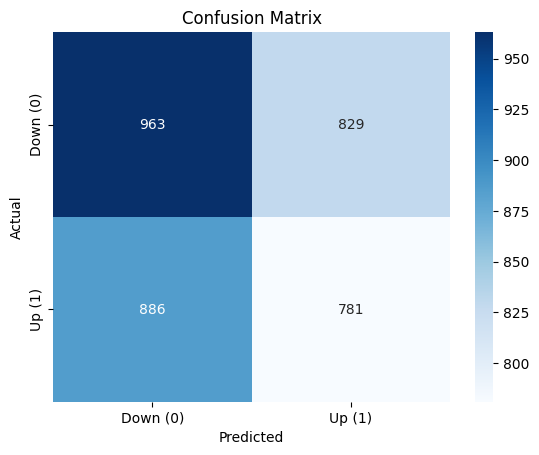

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down (0)', 'Up (1)'], 
                yticklabels=['Down (0)', 'Up (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred)
